In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

from rich import print
from tqdm import tqdm
from pathlib import Path
from ewatercycle_DA import DA
from datetime import datetime
from scipy.stats import qmc
from ipywidgets import IntProgress

## Loading in observed discharge data 

In [2]:
# Loading in discharge data from Katima Mulilo
katima = (pd.read_csv('Katima_Mulilo/1291100_Q_Day.txt', skiprows=35, delimiter=';', header=1)
    .drop(columns=['hh:mm'])
    .rename(columns={"YYYY-MM-DD": "Date", " Value": "Discharge [m^3/s]"}))

# Creating a dataframe with accessible dates and no invalid data 
katima['Date'] = pd.to_datetime(katima['Date'])
katima['Discharge [m^3/s]'] = katima['Discharge [m^3/s]'].replace(-999.000, np.nan)

# Defining the data period
start_calibration = '1986-01-01'
end_calibration = '2019-12-31'

# Reducing the dataframe to the calibration period
km = katima[(katima['Date'] >= start_calibration) & (katima['Date'] <= end_calibration)]

# Creating a dataframe of the flow data 
flow = pd.DataFrame(data=km['Discharge [m^3/s]'].values, index=km['Date'], columns=['Q'])

## Generating (or loading in) ERA5 forcings

In [3]:
#Defining the location of the shape file to be used
km_shp = Path.home() / "BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG" /  "km_ERA5" / "km.shp"

#Defining the forcings directory
ERA5_folder = Path.home() / "ERA5"
ERA5_folder.mkdir(exist_ok=True)

# HBV model path 
HBV_model_path = Path.home() / "HBV_model"

# OPTION 1: Generating ERA5 forcings
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset="ERA5",
#    start_time= data_start,
#    end_time= data_end,
#    shape=km_shp,
#    directory=ERA5_folder)

# OPTION 2: Generating ERA5 forcings (For when ERA5 forcing has already been made before and exists in the directory)
load_location = ERA5_folder / "work" / "diagnostic" / "script" 
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

## Best-fit parameters (determined in calibration)

In [29]:
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
params_RMSE = [1.22864548, 0.49355138, 364.49148991, 1.29074532, 0.27950672, 9.17057444, 0.01531569, 0.00185065, 0.37790522]
params_KGE = [0.24220498, 0.21354526, 669.18209942, 2.43548375, 0.1490909, 8.97407974, 0.04004892, 0.00057849, 0.19938798]

# Define the initial state parameters (Si,  Su, Sf, Ss, Sp)
s_0 = np.array([0,  100,  0,  5,  0])

## Running the model with the best-fit parameters

In [9]:
modelRMSE = ewatercycle.models.HBV(forcing=ERA5_forcing)
config_file_RMSE, _ = model.setup(parameters=params_RMSE, initial_storage=s_0, cfg_dir = HBV_model_path)

In [10]:
modelRMSE.initialize(config_file_RMSE)

In [11]:
Q_m_RMSE = []
time_RMSE = []
while modelRMSE.time < modelRMSE.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [12]:
model.finalize()

## Graphing the simulated and observed discharge

In [15]:
# The HBV model returns values in mm/day so in order to compare this to the observed data it must b converted to m^3/s
catchment_area_km2 = 334882.8

def mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

<Figure size 1600x1000 with 0 Axes>

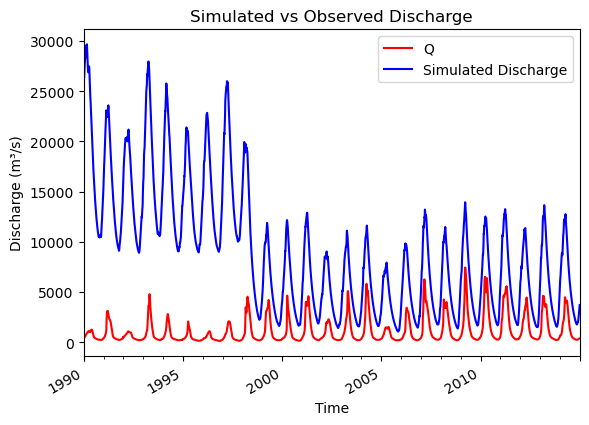

In [20]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Q_sim = mmday_to_m3s(model_output.values, catchment_area_km2)
Q_sim_pd = pd.Series(Q_sim, index=model_output.index, name="Simulated Discharge")

# get the right period
Q_sim_9719 = Q_sim_pd["1989-12-31":"2014-12-31"]
Q_obs_9719 = flow["1989-12-31":"2014-12-31"]

# plot
plt.figure(figsize=(16, 10))
Q_obs_9719.plot(label="Observed Discharge", color='red')
Q_sim_9719.plot(label="Simulated Discharge", color='blue')
plt.title('Simulated vs Observed Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge (m³/s)')
plt.legend()
plt.show()

In [21]:
paramsKGE = [5.94589424e+00, 9.44340159e-01, 3.62380790e+02, 8.38720310e-01, 2.37515550e-01, 5.75145126e+00, 6.64406174e-02, 5.61700659e-03, 1.38748689e-01]

In [22]:
model = ewatercycle.models.HBV(forcing=ERA5_forcing)
config_file, _ = model.setup(parameters=paramsKGE, initial_storage=s_0, cfg_dir = HBV_model_path)

In [24]:
model.initialize(config_file)

In [25]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [26]:
model.finalize()

<Figure size 1600x1000 with 0 Axes>

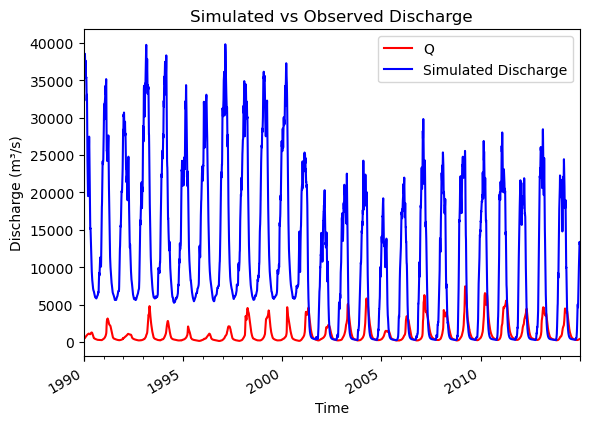

In [27]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Q_sim = mmday_to_m3s(model_output.values, catchment_area_km2)
Q_sim_pd = pd.Series(Q_sim, index=model_output.index, name="Simulated Discharge")

# get the right period
Q_sim_9719 = Q_sim_pd["1989-12-31":"2014-12-31"]
Q_obs_9719 = flow["1989-12-31":"2014-12-31"]

# plot
plt.figure(figsize=(16, 10))
Q_obs_9719.plot(label="Observed Discharge", color='red')
Q_sim_9719.plot(label="Simulated Discharge", color='blue')
plt.title('Simulated vs Observed Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge (m³/s)')
plt.legend()
plt.show()